# 06 — Asian Options

Asian options are **path-dependent** derivatives whose payoff depends on the average price of the underlying over a specified observation period, rather than the spot price at a single expiry date.

By basing the payoff on an average, these contracts reduce sensitivity to short-term price fluctuations and extreme moves at maturity. This typically lowers payoff volatility relative to standard European options and makes Asian options attractive for hedging exposures that arise gradually over time — particularly in commodity, FX, and equity-linked markets.

**Roadmap**

1. Notebook setup (imports, parameters)
2. What makes Asian options path-dependent?
3. Arithmetic vs geometric averaging
4. Analytical closed-form solutions (European)
5. Monte Carlo pricing via stochastic simulation
6. Binomial tree pricing — MC on the tree and Hull representative averages
7. American exercise for Asian options
8. Forward-starting Asians (`averaging_start > pricing_date`)
9. Discrete dividends
10. Seasoned (in-progress) Asians
11. Convergence comparison across methods
12. Summary

## 1) Notebook Setup

We use the `portfolio_analytics` package for all pricing.  Key objects:

| Class / Enum | Purpose |
|---|---|
| `DiscountCurve.flat(...)` | Flat risk-free rate curve |
| `MarketData` | Bundles pricing date + discount curve |
| `UnderlyingPricingData` | Spot, vol, market data, dividends |
| `AsianOptionSpec` | Asian contract terms (averaging, strike, maturity, exercise) |
| `OptionValuation` | Dispatcher — routes to the appropriate engine |
| `MonteCarloParams` | Paths, seed, LSM degree, ridge regularisation |
| `BinomialParams` | Tree steps, MC paths or Hull average buckets |
| `PricingMethod` | `BSM` (analytical), `MONTE_CARLO`, `BINOMIAL` |
| `AsianAveraging` | `ARITHMETIC` or `GEOMETRIC` |
| `GBMProcess` / `SimulationConfig` | GBM path simulator + grid configuration |

In [ ]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from portfolio_analytics import (
    DiscountCurve,
    MarketData,
    OptionType,
    ExerciseType,
    PricingMethod,
    AsianAveraging,
    MonteCarloParams,
    BinomialParams,
    OptionSpec,
    AsianOptionSpec,
    OptionValuation,
    UnderlyingPricingData,
    SimulationConfig,
    GBMParams,
    GBMProcess,
)

from portfolio_analytics.utils import calculate_year_fraction, pv_discrete_dividends

In [2]:
# ── Market / contract parameters ──────────────────────────────────────
pricing_date = dt.datetime(2025, 1, 1)
maturity = dt.datetime(2026, 1, 1)

S0 = 100.0  # spot
K = 100.0  # strike (ATM)
sigma = 0.20  # volatility
r = 0.05  # risk-free rate
q = 0.02  # continuous dividend yield
T = 1.0  # year fraction (for display)

# Build flat curves
curve_r = DiscountCurve.flat(r, end_time=T)
curve_q = DiscountCurve.flat(q, end_time=T)

market_data = MarketData(pricing_date, curve_r, currency="USD")

underlying = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data,
    dividend_curve=curve_q,
)

# Number of equally-spaced observation dates for the Asian average
N_OBS = 60  # 60 steps → 61 observation prices (including t=0)
ASIAN_TREE_AVERAGES = 100  # number of averages for Hull's tree approximation (see below)

print(f"Spot: {S0},  Strike: {K},  σ: {sigma},  r: {r},  q: {q},  T: {T}")
print(f"Observation steps: {N_OBS} → {N_OBS + 1} prices in the average")

Spot: 100.0,  Strike: 100.0,  σ: 0.2,  r: 0.05,  q: 0.02,  T: 1.0
Observation steps: 60 → 61 prices in the average


## 2) What Makes Asian Options Path-Dependent?

A **vanilla** European option's payoff depends only on the terminal spot price $S_T$:

$$\text{Call payoff} = \max(S_T - K,\; 0)$$

An **Asian** option replaces $S_T$ with an *average* of spot prices observed at discrete dates
$t_0, t_1, \dots, t_N$ over an averaging window $[t_s, T]$:

$$\bar{S} = \frac{1}{M}\sum_{i=0}^{N} S(t_i) \qquad \text{(arithmetic)}$$

$$\text{Asian call payoff} = \max(\bar{S} - K,\; 0)$$

where $M = N + 1$ is the total number of observations and $t_i = t_s + i \cdot \Delta$ with
$\Delta = (T - t_s)/N$.

Because the payoff depends on the *entire path* of $S$ (not just the endpoint), Asian options
are **path-dependent**.  This has several important consequences:

- **No simple closed-form** for arithmetic averages (the sum of lognormals is not lognormal)
- **Lower price** than the corresponding vanilla option (averaging reduces effective volatility)
- **Resistant to manipulation**: hard to spike the average vs a single fixing date
- The **state space** grows: at any point in time you need both $S_t$ *and* the running average $\bar{S}_t$ to value the option — this is why trees and PDEs struggle with Asians

### Average-price vs average-strike

This notebook focuses on **average-price** Asians: $\max(\bar{S} - K, 0)$.  The alternative is
the **average-strike** Asian: $\max(S_T - \bar{S}, 0)$, where the average replaces the strike.
`portfolio_analytics` currently supports average-price Asians.

## 3) Arithmetic vs Geometric Averaging

There are two standard averaging conventions:

### Arithmetic average

$$\bar{S}_{\text{arith}} = \frac{1}{M}\sum_{i=0}^{N} S(t_i)$$

This is by far the most common in practice (e.g. commodity settlements, structured products).

### Geometric average

$$\bar{S}_{\text{geom}} = \left(\prod_{i=0}^{N} S(t_i)\right)^{1/M} = \exp\!\left(\frac{1}{M}\sum_{i=0}^{N}\ln S(t_i)\right)$$

The geometric average is always **less than or equal to** the arithmetic average (AM-GM inequality).
Its key advantage is analytical tractability: under GBM, the geometric average of lognormal prices
is itself lognormal, yielding an **exact** closed-form price.

### Why both matter

| Property | Arithmetic | Geometric |
|---|---|---|
| Market convention | ✅ Most traded | ❌ Rare in practice |
| Closed-form price | ❌ Approximation only | ✅ Exact (Kemna-Vorst) |
| Control variate | Geometric serves as CV for arithmetic MC | — |

The geometric price also provides a **lower bound** for the arithmetic price (same strike),
which is useful as a sanity check.

## 4) Analytical Closed-Form Solutions (European)

`portfolio_analytics` implements two analytical approaches via `PricingMethod.BSM`:

### 4a) Geometric average — Kemna & Vorst (1990)

Under GBM the geometric average $G = (\prod S(t_i))^{1/M}$ is lognormal with moments:

$$E[\ln G] = \ln S_0 + (r - q - \tfrac{1}{2}\sigma^2)\,\bar{t}$$

$$\text{Var}[\ln G] = \sigma^2\!\left(t_s + \frac{\Delta\,N(2N+1)}{6M}\right)$$

where $\bar{t} = t_s + N\Delta/2$ is the mean observation time and $M = N+1$.

The price is then a standard **Black-Scholes** formula applied to $G$:

$$C_{\text{geom}} = e^{-rT}\!\left[F_G\,\Phi(d_1) - K\,\Phi(d_2)\right]$$

where $F_G = \exp(E[\ln G] + \tfrac{1}{2}\text{Var}[\ln G])$ is the forward of the geometric average.

### 4b) Arithmetic average — Turnbull & Wakeman (1991)

The arithmetic average $\bar{S}$ is **not** lognormal, but its first two moments are known exactly:

$$M_1 = E[\bar{S}] = \frac{1}{M}\sum_i F_i, \qquad
  M_2 = E[\bar{S}^2] = \frac{1}{M^2}\sum_i\sum_j F_i F_j\, e^{\sigma^2 \min(t_i, t_j)}$$

where $F_i = S_0 e^{(r-q)t_i}$.  A lognormal distribution is fitted to these moments and
**Black's model** is applied.  This is Hull's recommended approach (Section 26.13).

In [3]:
# ── Analytical prices ─────────────────────────────────────────────────

spec_geo_call = AsianOptionSpec(
    averaging=AsianAveraging.GEOMETRIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    num_steps=N_OBS,
    currency="USD",
)

spec_arith_call = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    num_steps=N_OBS,
    currency="USD",
)

spec_arith_put = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.PUT,
    strike=K,
    maturity=maturity,
    num_steps=N_OBS,
    currency="USD",
)

# PricingMethod.BSM dispatches to analytical formulas for AsianOptionSpec
geo_call_pv = OptionValuation(underlying, spec_geo_call, PricingMethod.BSM).present_value()
arith_call_pv = OptionValuation(underlying, spec_arith_call, PricingMethod.BSM).present_value()
arith_put_pv = OptionValuation(underlying, spec_arith_put, PricingMethod.BSM).present_value()

print("── Analytical (European) Asian Prices ──")
print(f"  Geometric call (Kemna-Vorst):          {geo_call_pv:.6f}")
print(f"  Arithmetic call (Turnbull-Wakeman):     {arith_call_pv:.6f}")
print(f"  Arithmetic put  (Turnbull-Wakeman):     {arith_put_pv:.6f}")
print()
print(f"  Arith call > Geom call? {arith_call_pv > geo_call_pv}  (AM-GM inequality)")

── Analytical (European) Asian Prices ──
  Geometric call (Kemna-Vorst):          4.964820
  Arithmetic call (Turnbull-Wakeman):     5.177309
  Arithmetic put  (Turnbull-Wakeman):     3.735968

  Arith call > Geom call? True  (AM-GM inequality)


### Geometric ≤ Arithmetic: an intuitive check

By the AM-GM inequality, $\bar{S}_{\text{geom}} \le \bar{S}_{\text{arith}}$ for any realisation.
Since the call payoff $\max(\bar{S} - K, 0)$ is increasing in $\bar{S}$, the geometric call
price is always **less than or equal to** the arithmetic call price (for the same strike).

This makes the geometric price a natural **lower bound** and a useful **control variate**
for Monte Carlo pricing of the arithmetic Asian.

## 5) Monte Carlo Pricing via Stochastic Simulation

For arithmetic Asians there is no exact closed-form, so Monte Carlo is the workhorse method.
The idea is as follows:

1. Simulate $I$ paths of $S$ on a grid $t_0, t_1, \dots, t_N$
2. For each path $i$, compute the average $\bar{S}^{(i)}$
3. Compute the payoff: $\phi^{(i)} = \max(\bar{S}^{(i)} - K, 0)$
4. Discount and average: $\hat{C} = e^{-rT} \cdot \frac{1}{I}\sum_i \phi^{(i)}$

`portfolio_analytics` does this automatically when you pass a `GBMProcess` with
`PricingMethod.MONTE_CARLO`.  The `SimulationConfig(num_steps=N)` creates $N+1$
equally-spaced points on the grid — exactly the $M = N+1$ observation prices
entering the average.

In [ ]:
# ── MC setup ──────────────────────────────────────────────────────────
MC_PATHS = 200_000
MC_SEED = 42

sim = SimulationConfig(
    paths=MC_PATHS,
    end_date=maturity,
    num_steps=N_OBS,
)

gbm = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(initial_value=S0, volatility=sigma, dividend_curve=curve_q),
    sim=sim,
)

mc_params = MonteCarloParams(random_seed=MC_SEED)

# ── Asian specs (no num_steps needed — MC uses the simulation grid) ──
spec_mc_arith_call = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
)

spec_mc_geo_call = AsianOptionSpec(
    averaging=AsianAveraging.GEOMETRIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
)

mc_arith = OptionValuation(gbm, spec_mc_arith_call, PricingMethod.MONTE_CARLO, mc_params)
mc_geo = OptionValuation(gbm, spec_mc_geo_call, PricingMethod.MONTE_CARLO, mc_params)

mc_arith_pv = mc_arith.present_value()
mc_geo_pv = mc_geo.present_value()

print("── Monte Carlo Asian Prices ──")
print(f"  Arithmetic call (MC):  {mc_arith_pv:.6f}   (analytical: {arith_call_pv:.6f})")
print(f"  Geometric  call (MC):  {mc_geo_pv:.6f}   (analytical: {geo_call_pv:.6f})")
print()
print(f"  Arith MC error:  {mc_arith_pv - arith_call_pv:+.6f}")
print(f"  Geom  MC error:  {mc_geo_pv - geo_call_pv:+.6f}")

In [ ]:
# ── Monte Carlo (GBM) ──────────────────────────────────────────────────
spec_mc_arith_call = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
)

spec_mc_geo_call = AsianOptionSpec(
    averaging=AsianAveraging.GEOMETRIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
)

mc_arith = OptionValuation(gbm, spec_mc_arith_call, PricingMethod.MONTE_CARLO, mc_params)
mc_geo = OptionValuation(gbm, spec_mc_geo_call, PricingMethod.MONTE_CARLO, mc_params)

mc_arith_pv = mc_arith.present_value()
mc_geo_pv = mc_geo.present_value()

arith_err = mc_arith_pv - arith_call_pv
arith_pct_err = 100.0 * arith_err / arith_call_pv if arith_call_pv != 0 else float("nan")
geo_err = mc_geo_pv - geo_call_pv
geo_pct_err = 100.0 * geo_err / geo_call_pv if geo_call_pv != 0 else float("nan")

print("── Monte Carlo Asian Prices ──")
print(f"  Arithmetic call (MC):  {mc_arith_pv:.6f}   (analytical: {arith_call_pv:.6f})")
print(f"  Geometric  call (MC):  {mc_geo_pv:.6f}   (analytical: {geo_call_pv:.6f})")
print()
print(f"  Arith MC error:  {arith_err:+.6f}  ({arith_pct_err:+.3f}%)")
print(f"  Geom  MC error:  {geo_err:+.6f}  ({geo_pct_err:+.3f}%)")

── Monte Carlo Asian Prices ──
  Arithmetic call (MC):  5.184694   (analytical: 5.177309)
  Geometric  call (MC):  4.987630   (analytical: 4.964820)

  Arith MC error:  +0.007385
  Geom  MC error:  +0.022810


### Path visualisation

Let's draw a few simulated GBM paths and shade the averaging window.  The Asian payoff
depends on the mean value of each path across the entire shaded region, not just the endpoint.

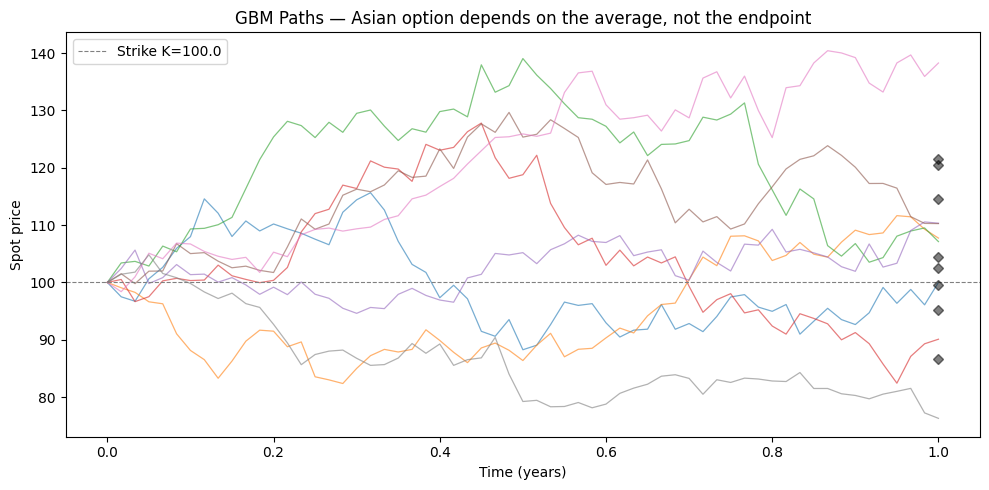

In [5]:
# ── Spaghetti plot of GBM paths ──────────────────────────────────────
n_show = 8

sim_viz = SimulationConfig(
    paths=n_show,
    end_date=maturity,
    num_steps=N_OBS,
    antithetic=False,
    moment_matching=False,
)
gbm_viz = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(initial_value=S0, volatility=sigma, dividend_curve=curve_q),
    sim=sim_viz,
)
paths_viz = gbm_viz.simulate(random_seed=123)
tg = gbm_viz.time_grid

# Convert time grid to year fractions for x-axis
t_yf = np.array([calculate_year_fraction(pricing_date, d) for d in tg])

fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_show):
    ax.plot(t_yf, paths_viz[:, i], alpha=0.6, linewidth=0.9)

ax.axhline(K, color="grey", linestyle="--", linewidth=0.8, label=f"Strike K={K}")

# Mark the arithmetic average for each path
for i in range(n_show):
    avg_i = np.mean(paths_viz[:, i])
    ax.plot(T, avg_i, "D", markersize=5, color="black", alpha=0.5)

ax.set_xlabel("Time (years)")
ax.set_ylabel("Spot price")
ax.set_title("GBM Paths — Asian option depends on the average, not the endpoint")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

## 6) Binomial Tree Pricing

Binomial trees are a natural framework for vanilla options, but Asian options pose a challenge:
the option's state at each node depends on the *path* taken to reach it, not just the node's
spot price.  A node at $(i, t)$ in a recombining CRR tree can be reached via many different
orderings of up/down moves, each producing a **different running average**.

`portfolio_analytics` offers two tree-based approaches:

### 6a) Monte Carlo on the tree

Sample random up/down paths through the binomial tree (just like MC on a GBM lattice),
compute the average along each path, and discount the expected payoff.  This is specified
via `BinomialParams(mc_paths=...)`.

Pros: simple, handles any averaging type, scales well with steps.
Cons: MC noise.

### 6b) Hull's representative averages

John Hull's method (Chapter 26) augments each node with $k$ representative average values
linearly spaced between the node's attainable minimum and maximum averages.
Backward induction then interpolates continuation values from the child nodes' average grids.

This method is specified via `BinomialParams(asian_tree_averages=k)`.

Pros: deterministic (no MC noise), works for European and **American** exercise.
Cons: memory is $O(k \cdot N^2)$; accuracy depends on $k$ and $N$.

**Key insight**: the min/max running average at node $(i, t)$ corresponds to the path where all
down moves come first (min) or all up moves come first (max).  This defines the feasible
average range at every node.

For **geometric** averaging the state variable is stored in log space:
$\ln\bar{S}_{\text{geom}} = \frac{1}{t+1}\sum_{j=0}^{t} \ln S_j$.

In [ ]:
# ── Binomial MC on CRR tree ────────────────────────────────────────────
binom_mc_params = BinomialParams(
    num_steps=N_OBS,
    mc_paths=200_000,
    random_seed=42,
)

spec_binom_arith_call = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
)

binom_mc_arith = OptionValuation(
    underlying, spec_binom_arith_call, PricingMethod.BINOMIAL, binom_mc_params
)
binom_mc_pv = binom_mc_arith.present_value()

err = binom_mc_pv - arith_call_pv
pct_err = 100.0 * err / arith_call_pv if arith_call_pv != 0 else float("nan")

print("── Binomial MC on Tree ──")
print(f"  Arithmetic call:  {binom_mc_pv:.6f}   (analytical: {arith_call_pv:.6f})")
print(f"  Error: {err:+.6f}  ({pct_err:+.3f}%)")

── Binomial MC on Tree ──
  Arithmetic call:  5.181332   (analytical: 5.177309)
  Error: +0.004023


In [ ]:
# ── Hull representative averages ──────────────────────────────────────
hull_params = BinomialParams(
    num_steps=N_OBS,
    asian_tree_averages=ASIAN_TREE_AVERAGES,  # ~1x num_steps is a good rule of thumb
)

# European geometric (exact analytical benchmark available)
spec_hull_geo = AsianOptionSpec(
    averaging=AsianAveraging.GEOMETRIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
    exercise_type=ExerciseType.EUROPEAN,
)

# European arithmetic
spec_hull_arith = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
    exercise_type=ExerciseType.EUROPEAN,
)

hull_geo_pv = OptionValuation(
    underlying, spec_hull_geo, PricingMethod.BINOMIAL, hull_params
).present_value()
hull_arith_pv = OptionValuation(
    underlying, spec_hull_arith, PricingMethod.BINOMIAL, hull_params
).present_value()

geo_err = hull_geo_pv - geo_call_pv
geo_pct_err = 100.0 * geo_err / geo_call_pv if geo_call_pv != 0 else float("nan")
arith_err = hull_arith_pv - arith_call_pv
arith_pct_err = 100.0 * arith_err / arith_call_pv if arith_call_pv != 0 else float("nan")

print("── Hull Representative Averages (European) ──")
print(f"  Geometric call:   {hull_geo_pv:.6f}   (analytical: {geo_call_pv:.6f})")
print(f"  Arithmetic call:  {hull_arith_pv:.6f}   (analytical: {arith_call_pv:.6f})")
print()
print(f"  Geom  error: {geo_err:+.6f}  ({geo_pct_err:+.3f}%)")
print(f"  Arith error: {arith_err:+.6f}  ({arith_pct_err:+.3f}%)")

── Hull Representative Averages (European) ──
  Geometric call:   4.999172   (analytical: 4.964820)
  Arithmetic call:  5.193662   (analytical: 5.177309)

  Geom  error: +0.034352
  Arith error: +0.016353


## 7) American Exercise for Asian Options

American-style Asian options allow the holder to exercise at any observation date, receiving
$\max(\bar{S}_t - K, 0)$ where $\bar{S}_t$ is the running average up to time $t$.

### Why American Asians are hard

The exercise decision at time $t$ requires comparing:
- **Intrinsic value**: $\max(\bar{S}_t - K, 0)$ (exercise now)
- **Continuation value**: $E_t[e^{-r\Delta t} \cdot V_{t+1}]$ (hold and decide later)

The state variable is **two-dimensional**: $(S_t, \bar{S}_t)$.  The running average $\bar{S}_t$
is a sufficient statistic for the path history relevant to the payoff, so the pair $(S_t, \bar{S}_t)$
is Markov.

### 7a) Longstaff-Schwartz with running average

`portfolio_analytics` extends the standard Longstaff-Schwartz (2001) algorithm by regressing
continuation values onto a **2-D polynomial basis** in $(S_t, \bar{S}_t)$:

$$\hat{V}_{\text{cont}}(t) = \sum_{i+j \le d} \beta_{ij}\, \hat{S}_t^i \, \hat{\bar{S}}_t^j$$

where $\hat{S}$ and $\hat{\bar{S}}$ are standardised (zero-mean, unit-variance) and $d$ is the
polynomial degree (default 3).  Ridge regularisation stabilises the regression.

At each backward step, the holder exercises when the intrinsic payoff exceeds the estimated
continuation value:

$$V_t = \max\!\bigl(\text{intrinsic}_t,\; e^{-r\Delta t}\,V_{t+1}\bigr)$$

### 7b) Hull tree averages with early exercise

The Hull representative-average method naturally supports American exercise.  At each node,
backward induction compares the **interpolated continuation value** (discounted expected value
of holding) with the **intrinsic payoff** at each representative average level:

$$V(A_k, i, t) = \max\!\bigl(\text{intrinsic}(A_k),\; \text{continuation}(A_k)\bigr)$$

This is the tree analogue of comparing intrinsic vs discounted expected continuation —
exactly the same decision as in the vanilla American binomial tree, but now applied
per-average-bucket.

In [8]:
# ── American Asian options (MC LSM vs Hull tree) ───────────────────────

# (1) MC Longstaff-Schwartz with 2-D (S, A) regression
spec_american_arith = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.PUT,  # American put has meaningful early exercise premium
    strike=K,
    maturity=maturity,
    currency="USD",
    exercise_type=ExerciseType.AMERICAN,
)

spec_european_arith_put = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.PUT,
    strike=K,
    maturity=maturity,
    currency="USD",
    exercise_type=ExerciseType.EUROPEAN,
)

mc_am = OptionValuation(gbm, spec_american_arith, PricingMethod.MONTE_CARLO, mc_params)
mc_am_pv = mc_am.present_value()

mc_eu_put = OptionValuation(gbm, spec_european_arith_put, PricingMethod.MONTE_CARLO, mc_params)
mc_eu_put_pv = mc_eu_put.present_value()

# Analytical European put (Turnbull-Wakeman)
eu_put_analytical = OptionValuation(
    underlying,
    AsianOptionSpec(
        averaging=AsianAveraging.ARITHMETIC,
        call_put=OptionType.PUT,
        strike=K,
        maturity=maturity,
        num_steps=N_OBS,
        currency="USD",
    ),
    PricingMethod.BSM,
).present_value()

print("── American vs European Asian Put (Monte Carlo) ──")
print(f"  European put (analytical T-W): {eu_put_analytical:.6f}")
print(f"  European put (MC):             {mc_eu_put_pv:.6f}")
print(f"  American put (MC LSM):         {mc_am_pv:.6f}")
print(f"  Early exercise premium:        {mc_am_pv - mc_eu_put_pv:.6f}")

# (2) Hull tree representative averages with early exercise
hull_am_params = BinomialParams(num_steps=N_OBS, asian_tree_averages=ASIAN_TREE_AVERAGES)

spec_hull_am_put = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.PUT,
    strike=K,
    maturity=maturity,
    currency="USD",
    exercise_type=ExerciseType.AMERICAN,
)

spec_hull_eu_put = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.PUT,
    strike=K,
    maturity=maturity,
    currency="USD",
    exercise_type=ExerciseType.EUROPEAN,
)

hull_am_pv = OptionValuation(
    underlying, spec_hull_am_put, PricingMethod.BINOMIAL, hull_am_params
).present_value()
hull_eu_pv = OptionValuation(
    underlying, spec_hull_eu_put, PricingMethod.BINOMIAL, hull_am_params
).present_value()

print()
print("── American vs European Asian Put (Hull tree) ──")
print(f"  European put (Hull):    {hull_eu_pv:.6f}   (analytical: {eu_put_analytical:.6f})")
print(f"  American put (Hull):    {hull_am_pv:.6f}")
print(f"  Early exercise premium: {hull_am_pv - hull_eu_pv:.6f}")

── American vs European Asian Put (Monte Carlo) ──
  European put (analytical T-W): 3.735968
  European put (MC):             3.735800
  American put (MC LSM):         4.312571
  Early exercise premium:        0.576771

── American vs European Asian Put (Hull tree) ──
  European put (Hull):    3.752321   (analytical: 3.735968)
  American put (Hull):    4.324205
  Early exercise premium: 0.571884


### Note on American Asian exercise

The early exercise premium for Asian options is typically small relative to vanilla Americans.
The averaging effect means that even if the current spot moves deep in-the-money, the
running average is smoothed and may not justify early exercise.

For **puts**, the premium is generally positive (exercising to capture the current favourable
average before it decays).  For **calls** with a dividend yield $q > 0$, there can be a small
premium for the same reason.

The two methods — MC Longstaff-Schwartz and Hull tree — should produce consistent results.
Differences arise from:
- **MC noise** (reduces with more paths)
- **Tree interpolation bias** (reduces with more `asian_tree_averages` and `num_steps`)

## 8) Forward-Starting Asians (`averaging_start > pricing_date`)

In many structured products the averaging window begins at some future date $t_s > 0$,
not at the pricing date.  For example, a 1-year option where averaging starts at the 6-month
mark.

During $[0, t_s)$ the option behaves like a forward-start: the spot diffuses freely but no
observations accumulate.  From $t_s$ onward, observations begin and the running average is built.

### Why this matters for simulation

When you construct a `GBMProcess` with `SimulationConfig(num_steps=N)`, a uniform dense grid would
normally place $N$ intervals across the full $[0, T]$ horizon.  For a forward-starting Asian we
instead want those $N$ intervals to lie in the **averaging window** $[t_s, T]$.

`portfolio_analytics` handles this automatically when you build an `OptionValuation` with a
`PathSimulation` underlying and an `AsianOptionSpec(averaging_start=...)`: the valuation will
internally **clone** the process via `underlying.replace(grid_start=averaging_start)` (it does not
mutate your existing `GBMProcess`).  With `grid_start` set, the dense grid places `num_steps`
equally spaced intervals in $[t_s, T]$; the time grid still includes the original `pricing_date`
as a point before $t_s$.

Note: the current binomial Asian implementations do not support `averaging_start > pricing_date`,
so forward-starting examples below use analytical (BSM) and Monte Carlo only.

In [ ]:
# ── Forward-starting Asian ────────────────────────────────────────────
averaging_start = dt.datetime(2025, 7, 1)  # 6 months in
T_avg = calculate_year_fraction(averaging_start, maturity)

spec_fwd_arith = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    averaging_start=averaging_start,
    num_steps=N_OBS,  # for analytical pricing
    currency="USD",
)

spec_fwd_geo = AsianOptionSpec(
    averaging=AsianAveraging.GEOMETRIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    averaging_start=averaging_start,
    num_steps=N_OBS,
    currency="USD",
)

# Analytical
fwd_arith_analytical = OptionValuation(
    underlying, spec_fwd_arith, PricingMethod.BSM
).present_value()
fwd_geo_analytical = OptionValuation(underlying, spec_fwd_geo, PricingMethod.BSM).present_value()

# MC — grid_start is set automatically by OptionValuation
spec_fwd_mc = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    averaging_start=averaging_start,
    currency="USD",
)

sim_fwd = SimulationConfig(
    paths=MC_PATHS,
    end_date=maturity,
    num_steps=N_OBS,  # 61 points land in [averaging_start, maturity]
)

gbm_fwd = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(initial_value=S0, volatility=sigma, dividend_curve=curve_q),
    sim=sim_fwd,
)

mc_fwd_pv = OptionValuation(
    gbm_fwd, spec_fwd_mc, PricingMethod.MONTE_CARLO, mc_params
).present_value()

print("── Forward-Starting Asian (averaging starts at 6M) ──")
print(f"  Averaging window: {averaging_start.date()} → {maturity.date()}")
print(f"  T_avg = {T_avg:.4f} years")
print()
print(f"  Geometric call (analytical):   {fwd_geo_analytical:.6f}")
print(f"  Arithmetic call (analytical):  {fwd_arith_analytical:.6f}")
print(f"  Arithmetic call (MC):          {mc_fwd_pv:.6f}")
print(f"  MC vs analytical error:        {mc_fwd_pv - fwd_arith_analytical:+.6f}")

In [ ]:
# ── Forward-starting Asian (averaging starts at 6M) ────────────────────
spec_fwd_arith = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    averaging_start=averaging_start,
    num_steps=N_OBS,
    currency="USD",
)
spec_fwd_geo = AsianOptionSpec(
    averaging=AsianAveraging.GEOMETRIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    averaging_start=averaging_start,
    num_steps=N_OBS,
    currency="USD",
)

fwd_arith_analytical = OptionValuation(
    underlying, spec_fwd_arith, PricingMethod.BSM
).present_value()
fwd_geo_analytical = OptionValuation(underlying, spec_fwd_geo, PricingMethod.BSM).present_value()

# MC — grid_start is set automatically by OptionValuation
spec_fwd_mc = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    averaging_start=averaging_start,
    currency="USD",
)

sim_fwd = SimulationConfig(
    paths=MC_PATHS,
    end_date=maturity,
    num_steps=N_OBS,  # 61 points land in [averaging_start, maturity]
)

gbm_fwd = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(initial_value=S0, volatility=sigma, dividend_curve=curve_q),
    sim=sim_fwd,
)

mc_fwd_pv = OptionValuation(
    gbm_fwd, spec_fwd_mc, PricingMethod.MONTE_CARLO, mc_params
).present_value()

err = mc_fwd_pv - fwd_arith_analytical
pct_err = 100.0 * err / fwd_arith_analytical if fwd_arith_analytical != 0 else float("nan")

print("── Forward-Starting Asian (averaging starts at 6M) ──")
print(f"  Averaging window: {averaging_start.date()} → {maturity.date()}")
print(f"  T_avg = {T_avg:.4f} years")
print()
print(f"  Geometric call (analytical):   {fwd_geo_analytical:.6f}")
print(f"  Arithmetic call (analytical):  {fwd_arith_analytical:.6f}")
print(f"  Arithmetic call (MC):          {mc_fwd_pv:.6f}")
print(f"  MC vs analytical error:        {err:+.6f}  ({pct_err:+.3f}%)")

── Forward-Starting Asian (averaging starts at 6M) ──
  Averaging window: 2025-07-01 → 2026-01-01
  T_avg = 0.5041 years

  Geometric call (analytical):   7.282263
  Arithmetic call (analytical):  7.384314
  Arithmetic call (MC):          7.433069
  MC vs analytical error:        +0.048755


### Forward-starting vs spot-starting: price comparison

Forward-starting Asians are typically **more expensive** than spot-starting Asians (same
maturity, strike, etc.) because the averaging window is shorter, so there is less
volatility reduction from averaging.

In the limit where `averaging_start = maturity` (a single observation), the Asian
degenerates to a vanilla European.

In [10]:
# ── Forward-start vs spot-start comparison ────────────────────────────

# Spot-starting (averaging over full [0, T])
spot_start_pv = arith_call_pv

# Forward-starting (averaging over [0.5, 1.0])
fwd_start_pv = fwd_arith_analytical

# Almost-vanilla (averaging starts 1 day before maturity)
near_vanilla_spec = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    averaging_start=dt.datetime(2025, 12, 30),
    num_steps=2,
    currency="USD",
)
near_vanilla_pv = OptionValuation(underlying, near_vanilla_spec, PricingMethod.BSM).present_value()

# True vanilla BSM
vanilla_spec = OptionSpec(
    option_type=OptionType.CALL,
    exercise_type=ExerciseType.EUROPEAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)
vanilla_pv = OptionValuation(underlying, vanilla_spec, PricingMethod.BSM).present_value()

print("── Asian Price vs Averaging Window Length ──")
print(f"  Spot-starting  (0M → 12M avg):  {spot_start_pv:.6f}")
print(f"  Forward-start  (6M → 12M avg):  {fwd_start_pv:.6f}")
print(f"  Near-vanilla   (≈12M→12M avg):  {near_vanilla_pv:.6f}")
print(f"  Vanilla BSM European:            {vanilla_pv:.6f}")
print()
print("As the averaging window shrinks → Asian price converges to vanilla price.")

── Asian Price vs Averaging Window Length ──
  Spot-starting  (0M → 12M avg):  5.177309
  Forward-start  (6M → 12M avg):  7.384314
  Near-vanilla   (≈12M→12M avg):  9.207170
  Vanilla BSM European:            9.227006

As the averaging window shrinks → Asian price converges to vanilla price.


## 9) Discrete Dividends

Discrete dividends cause drops in the stock price at ex-dates, which directly affect the average.
How each pricing method handles them:

| Method | Discrete dividends | Notes |
|---|---|---|
| **Analytical** (BSM) | ❌ Not supported | T-W / K-V formulas assume continuous yield only |
| **Monte Carlo** | ✅ Supported | Simulates spot paths with cash-dividend jumps at ex-dates |
| **Binomial (MC on tree)** | ✅ Supported | Escrowed-dividend / prepaid-forward lattice + MC sampling |
| **Binomial (Hull avgs)** | ✅ Supported | Escrowed-dividend / prepaid-forward lattice + representative averages |

When discrete dividends are present, the analytical formula raises `UnsupportedFeatureError` — you must use MC or binomial.

### Why MC and binomial can disagree

Even with the same inputs, MC and binomial may produce different prices because they are (slightly) different **discrete-dividend models**:

- **MC (GBMProcess with discrete dividends)**: simulates the spot and applies an additive jump at each ex-date
  $$S_{t^+} = \max(S_{t^-} - D, 0).$$
- **Binomial**: builds an **escrowed-dividend / prepaid-forward** lattice by splitting the stock into a risky component and a riskless dividend component.
  A common view is to treat the risky process as the prepaid forward $S^* = S_0 - PV(\text{divs})$, then add back the PV of remaining dividends at each node.

A useful (but heuristic) adjustment is to scale volatility when using the prepaid-forward lattice, since
the risky component is smaller than $S_0$:

$$\sigma^* \approx \sigma \cdot \frac{S_0}{S_0 - PV(\text{divs})}.$$

This can move the binomial price closer to the MC result.

In [ ]:
# ── Discrete dividends: MC vs binomial ─────────────────────────────────
ex_date_1 = dt.datetime(2025, 4, 1)
ex_date_2 = dt.datetime(2025, 10, 1)
divs = [(ex_date_1, 2.0), (ex_date_2, 2.0)]  # two $2 dividends

underlying_div = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data,
    discrete_dividends=divs,
    # No continuous dividend yield — just the two discrete payments
)

spec_div_mc = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    currency="USD",
)

# MC with discrete dividends: simulate spot and subtract dividends at ex-dates
sim_div = SimulationConfig(paths=MC_PATHS, end_date=maturity, num_steps=N_OBS)
gbm_div = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(initial_value=S0, volatility=sigma, discrete_dividends=divs),
    sim=sim_div,
)
mc_div_pv = OptionValuation(
    gbm_div, spec_div_mc, PricingMethod.MONTE_CARLO, mc_params
).present_value()

# Binomial tree MC with discrete dividends: escrowed-dividend / prepaid-forward lattice
binom_div_params = BinomialParams(num_steps=200, mc_paths=200_000, random_seed=42)
binom_div_pv = OptionValuation(
    underlying_div, spec_div_mc, PricingMethod.BINOMIAL, binom_div_params
).present_value()

# Heuristic: volatility adjustment for the prepaid-forward risky component
pv_divs = pv_discrete_dividends(
    divs,
    pricing_date,
    maturity,
    market_data.discount_curve,
)
vol_multiplier = S0 / (S0 - pv_divs)
underlying_div_vol_adj = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma * vol_multiplier,
    market_data=market_data,
    discrete_dividends=divs,
)
binom_div_pv_vol_adj = OptionValuation(
    underlying_div_vol_adj, spec_div_mc, PricingMethod.BINOMIAL, binom_div_params
).present_value()

print("── Discrete Dividends: European Arithmetic Asian Call ──")
print(f"  No dividends (MC):                 {mc_arith_pv:.6f}")
print(f"  With 2 × $2 divs (MC):            {mc_div_pv:.6f}")
print(f"  With 2 × $2 divs (binom):         {binom_div_pv:.6f}")
print(f"  With 2 × $2 divs (binom, σ* adj): {binom_div_pv_vol_adj:.6f}")
print()
print(f"  PV(divs) = {pv_divs:.6f}")
print(f"  σ* multiplier = {vol_multiplier:.6f}  →  σ* = {sigma * vol_multiplier:.6%}")

── Discrete Dividends: European Arithmetic Asian Call ──
  No dividends (MC):                 5.184694
  With 2 × $2 divs (MC):            4.690790
  With 2 × $2 divs (binom):         4.562654
  With 2 × $2 divs (binom, σ* adj): 4.738219

  PV(divs) = 3.902081
  σ* multiplier = 1.040605  →  σ* = 20.812105%


## 10) Seasoned (In-Progress) Asians

A **seasoned** Asian is one where part of the averaging window has already elapsed.  We have $n_1$
past fixings with observed average $\bar{S}_{\text{obs}}$ and $n_2$ future fixings remaining.

The payoff at maturity is:

$$\max\!\left(\frac{n_1 \bar{S}_{\text{obs}} + n_2 \bar{S}_{\text{future}}}{n_1 + n_2} - K,\; 0\right)$$

### Hull's adjusted-strike reduction (average-price calls)

This can be rewritten as:

$$\frac{n_2}{n_1 + n_2}\;\max\!\left(\bar{S}_{\text{future}} - K^*,\; 0\right)$$

where the **adjusted strike** is:

$$K^* = \frac{n_1 + n_2}{n_2}\,K - \frac{n_1}{n_2}\,\bar{S}_{\text{obs}}$$

When $K^* > 0$: price a fresh Asian with strike $K^*$ and scale by $n_2/(n_1 + n_2)$.

When $K^* \le 0$: for a **call**, the option is certain to be exercised and the value equals a
scaled forward-style value on the remaining average.  For a **put**, $K^* \le 0$ implies the
future payoff is $0$ (since the remaining average is positive).

`portfolio_analytics` handles this automatically when you provide `observed_average` and
`observed_count` on `AsianOptionSpec`.

In [12]:
# ── Seasoned Asian example ────────────────────────────────────────────
# Suppose 20 out of 61 fixings have been observed, with average $102
n1 = 20
n2 = N_OBS + 1 - n1  # 41 future fixings
S_bar_obs = 102.0

spec_seasoned = AsianOptionSpec(
    averaging=AsianAveraging.ARITHMETIC,
    call_put=OptionType.CALL,
    strike=K,
    maturity=maturity,
    num_steps=n2 - 1,  # future fixings use n2-1 steps → n2 prices
    currency="USD",
    observed_average=S_bar_obs,
    observed_count=n1,
)

seasoned_pv = OptionValuation(underlying, spec_seasoned, PricingMethod.BSM).present_value()

K_star = (n1 + n2) / n2 * K - n1 / n2 * S_bar_obs
scale = n2 / (n1 + n2)

print("── Seasoned Asian Call ──")
print(f"  n₁ = {n1} observed,  n₂ = {n2} remaining")
print(f"  Observed average S̄ = {S_bar_obs}")
print(f"  Adjusted strike K* = {K_star:.4f}")
print(f"  Scale factor = {scale:.4f}")
print(f"  Seasoned Asian PV = {seasoned_pv:.6f}")
print()
if K_star > 0:
    # Price the fresh Asian with K* for verification
    spec_fresh = AsianOptionSpec(
        averaging=AsianAveraging.ARITHMETIC,
        call_put=OptionType.CALL,
        strike=K_star,
        maturity=maturity,
        num_steps=n2 - 1,
        currency="USD",
    )
    fresh_pv = OptionValuation(underlying, spec_fresh, PricingMethod.BSM).present_value()
    print(
        f"  Verification: scale × fresh_PV(K*) = {scale:.4f} × {fresh_pv:.6f} = {scale * fresh_pv:.6f}"
    )

── Seasoned Asian Call ──
  n₁ = 20 observed,  n₂ = 41 remaining
  Observed average S̄ = 102.0
  Adjusted strike K* = 99.0244
  Scale factor = 0.6721
  Seasoned Asian PV = 3.814672

  Verification: scale × fresh_PV(K*) = 0.6721 × 5.675487 = 3.814672


## 11) MC Convergence

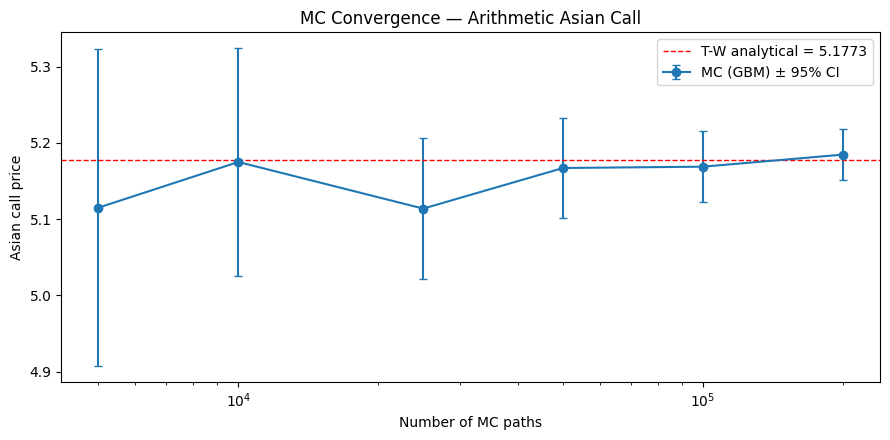


Analytical (T-W): 5.177309
    5,000 paths → 5.115105  (SE: 0.106186, 95% CI ±0.208125, err: -0.062204)
   10,000 paths → 5.175021  (SE: 0.076187, 95% CI ±0.149326, err: -0.002288)
   25,000 paths → 5.113870  (SE: 0.047331, 95% CI ±0.092769, err: -0.063440)
   50,000 paths → 5.167151  (SE: 0.033694, 95% CI ±0.066040, err: -0.010158)
  100,000 paths → 5.168889  (SE: 0.023883, 95% CI ±0.046810, err: -0.008420)
  200,000 paths → 5.184694  (SE: 0.016978, 95% CI ±0.033276, err: +0.007385)


In [ ]:
# ── Monte Carlo: price vs paths (with standard errors) ──────────────────
path_counts = [5_000, 10_000, 25_000, 50_000, 100_000, 200_000]
mc_prices: list[float] = []
mc_ses: list[float] = []

for n_paths in path_counts:
    sim_i = SimulationConfig(paths=n_paths, end_date=maturity, num_steps=N_OBS)
    gbm_i = GBMProcess(
        market_data=market_data,
        process_params=GBMParams(initial_value=S0, volatility=sigma, dividend_curve=curve_q),
        sim=sim_i,
    )
    ov_i = OptionValuation(gbm_i, spec_mc_arith_call, PricingMethod.MONTE_CARLO, mc_params)
    pv_pathwise = ov_i.present_value_pathwise()
    pv_i = float(np.mean(pv_pathwise))
    se_i = float(np.std(pv_pathwise, ddof=1) / np.sqrt(n_paths))
    mc_prices.append(pv_i)
    mc_ses.append(se_i)

ci95 = [1.96 * se for se in mc_ses]
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.errorbar(
    path_counts,
    mc_prices,
    yerr=ci95,
    fmt="o-",
    capsize=3,
    label="MC (GBM) ± 95% CI",
)
ax.axhline(
    arith_call_pv,
    color="red",
    linestyle="--",
    linewidth=1,
    label=f"T-W analytical = {arith_call_pv:.4f}",
)
ax.set_xlabel("Number of MC paths")
ax.set_ylabel("Asian call price")
ax.set_title("MC Convergence — Arithmetic Asian Call")
ax.legend()
ax.set_xscale("log")
plt.tight_layout()
plt.show()

print(f"\nAnalytical (T-W): {arith_call_pv:.6f}")
for n, p, se in zip(path_counts, mc_prices, mc_ses):
    err = p - arith_call_pv
    pct_err = 100.0 * err / arith_call_pv if arith_call_pv != 0 else float("nan")
    print(
        f"  {n:>7,} paths → {p:.6f}  (SE: {se:.6f}, 95% CI ±{1.96 * se:.6f}, err: {err:+.6f}, {pct_err:+.3f}%)"
    )

## 12) Summary

### Key takeaways

1. **Asian options are path-dependent**: the payoff depends on the average price over
   a window, not a single terminal value.  This makes them cheaper than vanillas
   (averaging reduces effective volatility).

2. **Arithmetic vs geometric**: arithmetic is the market standard but has no exact
   closed-form.  Geometric has an exact formula (Kemna-Vorst) and serves as a lower
   bound and control variate.

3. **Analytical pricing** (European only):
   - **Geometric**: Kemna-Vorst (1990) — exact BSM-like formula
   - **Arithmetic**: Turnbull-Wakeman (1991) — moment-matching approximation via Black's model

4. **Monte Carlo** handles all cases: European, American, arithmetic, geometric, discrete
   dividends, forward-starting.  Longstaff-Schwartz with 2-D $(S_t, \bar{S}_t)$ regression
   enables American exercise.

5. **Binomial trees** offer two modes:
   - **MC on tree**: sample random paths through CRR lattice
   - **Hull representative averages**: deterministic, memory $O(k \cdot N^2)$, supports
     both European and American exercise

6. **Forward-starting Asians** (`averaging_start > pricing_date`): the dense simulation grid
   is automatically shifted to cover $[t_s, T]$ via `grid_start`, ensuring correct step density
   in the averaging window.

7. **Discrete dividends** are handled by MC and binomial (not analytical).  They reduce the
   average and hence the call price.

8. **Seasoned Asians** with partial observations use Hull's adjusted-strike $K^*$ reduction
   to price as a scaled fresh Asian.

### Pricing method selection guide

| Scenario | Recommended method |
|---|---|
| European, quick estimate | `PricingMethod.BSM` (analytical T-W / K-V) |
| European, high accuracy | `PricingMethod.MONTE_CARLO` with many paths |
| American exercise | `PricingMethod.MONTE_CARLO` (LSM) or `BINOMIAL` (Hull tree) |
| Discrete dividends | `PricingMethod.MONTE_CARLO` or `BINOMIAL` |
| Seasoned (in-progress) | Any method — `AsianOptionSpec(observed_average=..., observed_count=...)` |